# Generate forcing in eWaterCycle with ESMValTool

This notebooks shows how to generate forcing data for PCR-GLOBWB model using ERA5 data and [ESMValTool hydrological recipes](https://docs.esmvaltool.org/en/latest/recipes/recipe_hydrology.html#pcr-globwb). More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) in the eWaterCycle documentation.

In [1]:
import logging
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", category=UserWarning)

logger = logging.getLogger("esmvalcore")
logger.setLevel(logging.WARNING)

In [2]:
import xarray as xr
from rich import print

import ewatercycle.forcing

Forcing for PCRGlobWB is created using the ESMValTool recipe. It produces one file per each variable: temperature, and precipitation. You can set the start and end date, and the region. See [eWaterCycle documentation](https://ewatercycle.readthedocs.io/en/latest/apidocs/ewatercycle.forcing.html#submodules) for more information. 

#### Bug:
A shape file needs to be provided to delineate the area of interest. However, the forcing generated in this way will fill a bounding box that is "tight" around the shapefile. PCRGlobWB needs forcing files to be (slightly) larger than the extend of the clonemap. We fix this with "esmavaltool_padding below. Furhtermore, the number of pixels in the lat and lon directions need to be even for the interpolation algorithm that converts forcing data to the grid of the model. Therefore, we use the extract region and hard-code the extend of Great Brittain.

In [3]:
experiment_start_date="1997-08-01T00:00:00Z"
experiment_end_date="2000-08-31T00:00:00Z"

In [4]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory="/home/rhut/forcing/caravan/hysets_09488650",
#     basin_id="hysets_09488650",
# )

In [5]:
# option two: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory="/home/rhut/forcing/caravan/hysets_09488650")

In [6]:
esmvaltool_padding = 2

pcrglobwb_forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].generate(
    dataset="ERA5",
    start_time="1997-08-01T00:00:00Z",
    end_time="2000-08-31T00:00:00Z",
    start_time_climatology="1997-08-01T00:00:00Z",
    end_time_climatology="1998-08-01T00:00:00Z",
    shape=camelsgb_forcing.shape,
    extract_region={
    "start_longitude": -116-esmvaltool_padding,
    "end_longitude": -110+esmvaltool_padding,
    "start_latitude": 25-esmvaltool_padding,
    "end_latitude": 34+esmvaltool_padding,},
    directory = "/home/rhut/forcing/sonoran_desert/"

)

In [7]:
print(pcrglobwb_forcing)

PCRGlobWBForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/forcing/sonoran_desert/work/diagnostic/script'),
    shape=PosixPath('/home/rhut/forcing/caravan/hysets_09488650/hysets_09488650.shp'),
    filenames={},
    precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_1997-2000_hysets_09488650.nc',
    temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_1997-2000_hysets_09488650.nc'
)

### Plot forcing

<xarray.Dataset> Size: 16MB
Dimensions:    (time: 1826, lat: 53, lon: 41, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1996-01-02 1996-01-03 ... 2000-12-31
  * lat        (lat) float32 212B 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * lon        (lon) float32 164B -118.0 -117.7 -117.5 ... -108.5 -108.2 -108.0
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 16MB 279.4 281.9 284.2 ... 294.8 295.1
    time_bnds  (time, bnds) datetime64[ns] 29kB 1996-01-01T12:00:00 ... 2000-...
    lat_bnds   (lat, bnds) float32 424B 36.12 35.88 35.88 ... 23.12 23.12 22.88
    lon_bnds   (lon, bnds) float32 328B -118.1 -117.9 -117.9 ... -108.1 -107.9
Attributes:
    Conventions:  CF-1.7
    software:     Created with ESMValTool v2.11.0
    caption:      Forcings for the PCR-GLOBWB hydrological model.

------------------------

<xarray.Dataset> Size: 16MB
Dimensions:    (time: 1826, lat: 53, lon: 41, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1996-01-02 1996-01-03 ... 2000-12-31
  * lat        (lat) float32 212B 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * lon        (lon) float32 164B -118.0 -117.7 -117.5 ... -108.5 -108.2 -108.0
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 16MB 6.481e-05 0.0003164 ... 0.0 0.0
    time_bnds  (time, bnds) datetime64[ns] 29kB 1996-01-01T12:00:00 ... 2000-...
    lat_bnds   (lat, bnds) float32 424B 36.12 35.88 35.88 ... 23.12 23.12 22.88
    lon_bnds   (lon, bnds) float32 328B -118.1 -117.9 -117.9 ... -108.1 -107.9
Attributes:
    Conventions:  CF-1.7
    software:     Created with ESMValTool v2.11.0
    caption:      Forcings for the PCR-GLOBWB hydrological model.

------------------------

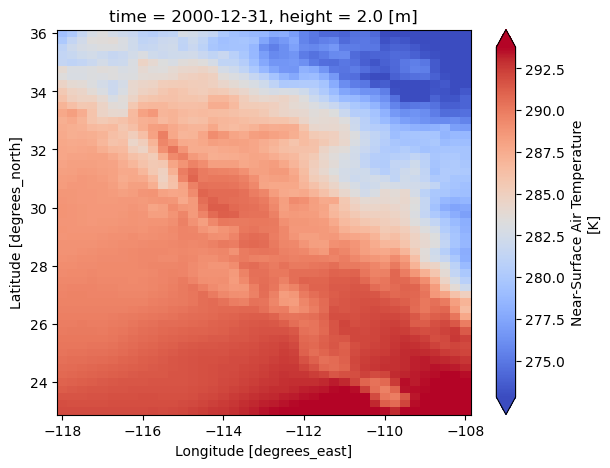

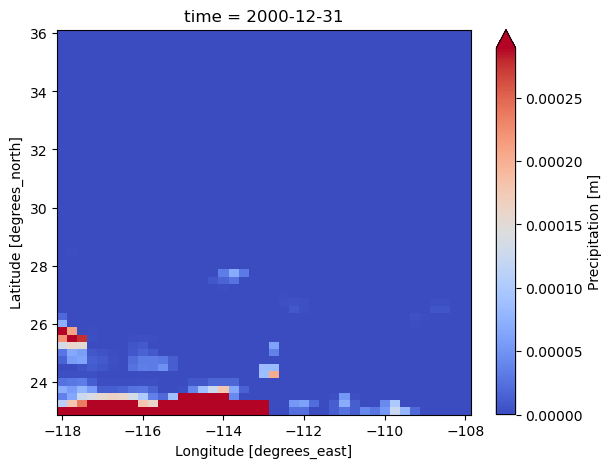

In [8]:
for file_name in [pcrglobwb_forcing.temperatureNC, pcrglobwb_forcing.precipitationNC]:
    dataset = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
    print(dataset)
    print("------------------------")
    var = list(dataset.data_vars.keys())[0]
    dataset[var].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)